In [2]:
df = pd.read_csv('../data/processed/traffic_atr_2023_clean.csv')

In [3]:
df.head()

,Vol,Yr,M,D,HH,MM,WktGeom,Boro,street,Direction,datetime_hour
0,353,2023,11,1,18,30,POINT (1002754.5374999298 235875.81836194085),Manhattan,MADISON AVENUE BRIDGE,EB,2023-11-01 18:30:00
1,330,2023,11,1,18,45,POINT (1002754.5374999298 235875.81836194085),Manhattan,MADISON AVENUE BRIDGE,EB,2023-11-01 18:45:00
2,345,2023,11,1,19,0,POINT (1002754.5374999298 235875.81836194085),Manhattan,MADISON AVENUE BRIDGE,EB,2023-11-01 19:00:00
3,338,2023,11,1,19,15,POINT (1002754.5374999298 235875.81836194085),Manhattan,MADISON AVENUE BRIDGE,EB,2023-11-01 19:15:00
4,321,2023,11,1,19,30,POINT (1002754.5374999298 235875.81836194085),Manhattan,MADISON AVENUE BRIDGE,EB,2023-11-01 19:30:00


## Feature Engineering for Traffic Data

Let's create useful features from our traffic data to better understand traffic patterns and their potential relationship with bike usage.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [5]:
df.dtypes

Vol               int64
Yr                int64
M                 int64
D                 int64
HH                int64
MM                int64
WktGeom          object
Boro             object
street           object
Direction        object
datetime_hour    object
dtype: object

In [6]:
# Ensure datetime_hour is in datetime format
df['datetime_hour'] = pd.to_datetime(df['datetime_hour'])

In [7]:
df.dtypes

Vol                       int64
Yr                        int64
M                         int64
D                         int64
HH                        int64
MM                        int64
WktGeom                  object
Boro                     object
street                   object
Direction                object
datetime_hour    datetime64[ns]
dtype: object

In [8]:
# 1. Temporal Features

# Day of week and weekend flag
df['day_of_week'] = df['datetime_hour'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 5=Saturday, 6=Sunday
df['day_name'] = df['datetime_hour'].dt.day_name()

# Time of day categories
time_bins = [0, 6, 10, 15, 19, 24]
time_labels = ['Early Morning', 'Morning Rush', 'Midday', 'Evening Rush', 'Night']
df['time_of_day'] = pd.cut(df['HH'], bins=time_bins, labels=time_labels, right=False)

# Season based on month
season_map = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
    11: 'Fall', 12: 'Winter'
}
df['season'] = df['M'].map(season_map)

# Peak hours flag (typical rush hours in cities)
morning_peak = (df['HH'] >= 7) & (df['HH'] <= 9)
evening_peak = (df['HH'] >= 16) & (df['HH'] <= 18)
df['is_peak_hour'] = (morning_peak | evening_peak).astype(int)

print("Temporal features created:")
for feature in ['day_of_week', 'day_name', 'is_weekend', 'time_of_day', 'season', 'is_peak_hour']:
    if feature in df.columns:
        if df[feature].dtype.name == 'category':
            print(f"- {feature}: {df[feature].cat.categories.tolist()}")
        else:
            print(f"- {feature}")

print("\nTime of day distribution:")
print(df['time_of_day'].value_counts())

Temporal features created:
- day_of_week
- day_name
- is_weekend
- time_of_day: ['Early Morning', 'Morning Rush', 'Midday', 'Evening Rush', 'Night']
- season
- is_peak_hour

Time of day distribution:
time_of_day
Early Morning    17832
Midday           14860
Night            14860
Morning Rush     11888
Evening Rush     11888
Name: count, dtype: int64


In [9]:
# 2. Traffic Volume Features

# Calculate mean and median volume by hour of day across all locations
hourly_avg = df.groupby('HH')['Vol'].mean().reset_index()
hourly_med = df.groupby('HH')['Vol'].median().reset_index()

# Use these to calculate relative volume compared to daily patterns
hourly_mean_map = dict(zip(hourly_avg['HH'], hourly_avg['Vol']))
df['hourly_mean_vol'] = df['HH'].map(hourly_mean_map)
df['rel_volume'] = df['Vol'] / df['hourly_mean_vol']

# Create volume categories based on percentiles
vol_bins = [0, df['Vol'].quantile(0.25), df['Vol'].quantile(0.5), 
            df['Vol'].quantile(0.75), df['Vol'].max()]
vol_labels = ['Low', 'Medium-Low', 'Medium-High', 'High']
df['volume_category'] = pd.cut(df['Vol'], bins=vol_bins, labels=vol_labels)

# Calculate z-score of volume for each location to find unusually high/low values
location_groups = df.groupby(['Boro', 'street', 'Direction'])
df['vol_zscore'] = location_groups['Vol'].transform(lambda x: (x - x.mean()) / x.std())
df['is_vol_outlier'] = (df['vol_zscore'].abs() > 2).astype(int)  # Flag outliers (>2 std dev)

print("\nTraffic volume features created:")
for feature in ['rel_volume', 'volume_category', 'vol_zscore', 'is_vol_outlier']:
    print(f"- {feature}")

print("\nVolume category distribution:")
print(df['volume_category'].value_counts())


Traffic volume features created:
- rel_volume
- volume_category
- vol_zscore
- is_vol_outlier

Volume category distribution:
volume_category
Medium-Low     17948
High           17764
Medium-High    17567
Low            16138
Name: count, dtype: int64


In [10]:
# 3. Spatial Features

# Borough encoding
if 'Boro' in df.columns:
    print("\nBorough distribution:")
    print(df['Boro'].value_counts())
    
    # One-hot encode boroughs
    boro_dummies = pd.get_dummies(df['Boro'], prefix='boro')
    df = pd.concat([df, boro_dummies], axis=1)
    
    # Borough traffic characteristics
    boro_mean_vol = df.groupby('Boro')['Vol'].mean().reset_index()
    boro_vol_map = dict(zip(boro_mean_vol['Boro'], boro_mean_vol['Vol']))
    df['boro_avg_vol'] = df['Boro'].map(boro_vol_map)
    df['boro_rel_vol'] = df['Vol'] / df['boro_avg_vol']

# Direction encoding
if 'Direction' in df.columns:
    print("\nDirection distribution:")
    print(df['Direction'].value_counts())
    
    # Map traffic direction to compass points if needed
    direction_map = {
        'NB': 'North',
        'SB': 'South',
        'EB': 'East',
        'WB': 'West',
        # Add more mappings if needed
    }
    # Apply mapping if direction values match the keys
    if set(df['Direction'].unique()).issubset(set(direction_map.keys())):
        df['direction_cardinal'] = df['Direction'].map(direction_map)
    
    # One-hot encode direction
    dir_dummies = pd.get_dummies(df['Direction'], prefix='dir')
    df = pd.concat([df, dir_dummies], axis=1)

# Street type/classification (if possible)
if 'street' in df.columns:
    # Count unique streets
    print(f"\nNumber of unique streets: {df['street'].nunique()}")
    
    # Identify most common streets (top 10)
    top_streets = df['street'].value_counts().head(10)
    print("\nTop 10 streets by frequency:")
    print(top_streets)
    
    # Flag major streets (top 10 by volume)
    high_vol_streets = df.groupby('street')['Vol'].mean().nlargest(10).index.tolist()
    df['is_major_street'] = df['street'].isin(high_vol_streets).astype(int)

print("\nSpatial features created:")
boro_features = [col for col in df.columns if col.startswith('boro_')]
dir_features = [col for col in df.columns if col.startswith('dir_')]
print(f"- Borough features: {len(boro_features)}")
print(f"- Direction features: {len(dir_features)}")
if 'is_major_street' in df.columns:
    print(f"- is_major_street")


Borough distribution:
Boro
Brooklyn         28508
Queens           15966
Manhattan        11970
Bronx            11616
Staten Island     3268
Name: count, dtype: int64

Direction distribution:
Direction
NB    18912
EB    17760
WB    17760
SB    16896
Name: count, dtype: int64

Number of unique streets: 91

Top 10 streets by frequency:
street
FLATBUSH AVENUE      4878
FOSTER AVENUE        3360
BELT PARKWAY         2592
3 AVENUE BRIDGE      2496
SUTTER AVENUE        2304
HOOK CREEK BRIDGE    2304
MYRTLE AVENUE        1912
BAY PARKWAY          1728
BAY STREET           1728
EAST 116 STREET      1728
Name: count, dtype: int64

Spatial features created:
- Borough features: 7
- Direction features: 4
- is_major_street


In [11]:
# 4. Combined and Advanced Features

# Traffic by day of week and hour (creates a unique pattern signature)
dow_hour_vol = df.groupby(['day_of_week', 'HH'])['Vol'].mean().reset_index()
dow_hour_key = dow_hour_vol.apply(lambda x: f"{int(x['day_of_week'])}_{int(x['HH'])}", axis=1)
dow_hour_val = dow_hour_vol['Vol'].values
dow_hour_map = dict(zip(dow_hour_key, dow_hour_val))

# Create a day-hour key in the main dataframe
df['dow_hour_key'] = df.apply(lambda x: f"{int(x['day_of_week'])}_{int(x['HH'])}", axis=1)
df['typical_vol_for_time'] = df['dow_hour_key'].map(dow_hour_map)
df['vol_vs_typical'] = df['Vol'] / df['typical_vol_for_time']

# Traffic congestion index (simplified)
# Higher values indicate more congestion relative to typical patterns
df['congestion_index'] = np.clip((df['Vol'] / df['typical_vol_for_time'] - 0.8) * 5, 0, 10)

# Create unique location identifier
if all(col in df.columns for col in ['Boro', 'street', 'Direction']):
    df['location_id'] = df['Boro'] + '_' + df['street'] + '_' + df['Direction']
    print(f"\nNumber of unique traffic monitoring locations: {df['location_id'].nunique()}")

# Weekday vs weekend volume ratio by location
if 'location_id' in df.columns:
    weekday_vol = df[df['is_weekend'] == 0].groupby('location_id')['Vol'].mean()
    weekend_vol = df[df['is_weekend'] == 1].groupby('location_id')['Vol'].mean()
    
    # Merge these back as a feature, handling locations with no weekend data
    weekday_vol_dict = weekday_vol.to_dict()
    weekend_vol_dict = weekend_vol.to_dict()
    
    df['location_weekday_vol'] = df['location_id'].map(weekday_vol_dict)
    df['location_weekend_vol'] = df['location_id'].map(weekend_vol_dict)
    
    # Calculate ratio where both values exist
    mask = (df['location_weekday_vol'].notna()) & (df['location_weekend_vol'].notna())
    df.loc[mask, 'weekday_weekend_ratio'] = df.loc[mask, 'location_weekday_vol'] / df.loc[mask, 'location_weekend_vol']

print("\nAdvanced features created:")
for feature in ['vol_vs_typical', 'congestion_index', 'weekday_weekend_ratio']:
    if feature in df.columns:
        non_null = df[feature].count()
        print(f"- {feature} (non-null values: {non_null})")


Number of unique traffic monitoring locations: 130

Advanced features created:
- vol_vs_typical (non-null values: 71328)
- congestion_index (non-null values: 71328)
- weekday_weekend_ratio (non-null values: 61798)


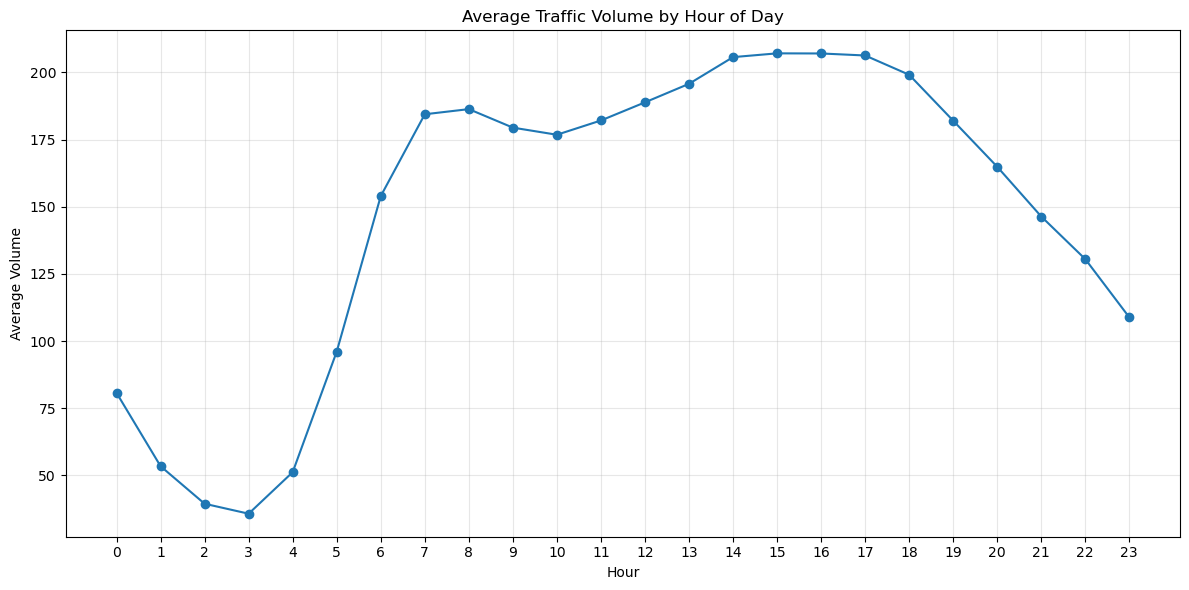

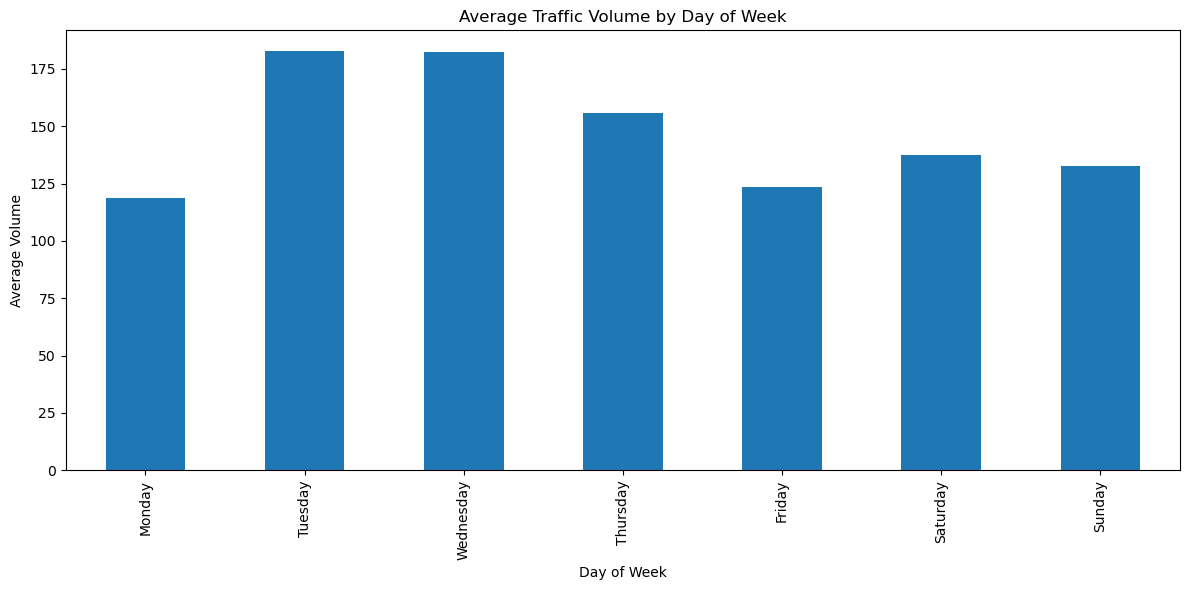

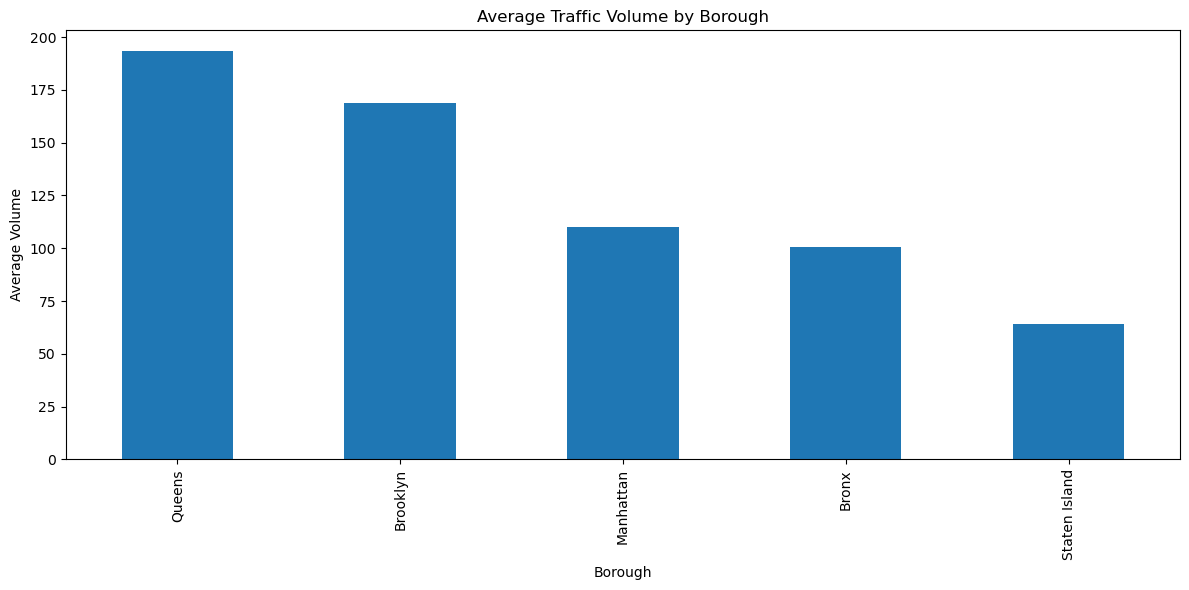

C:\Users\21654\AppData\Local\Temp\ipykernel_3248\2697576139.py:42: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = df.pivot_table(values='Vol', index='time_of_day', columns='day_name', aggfunc='mean')


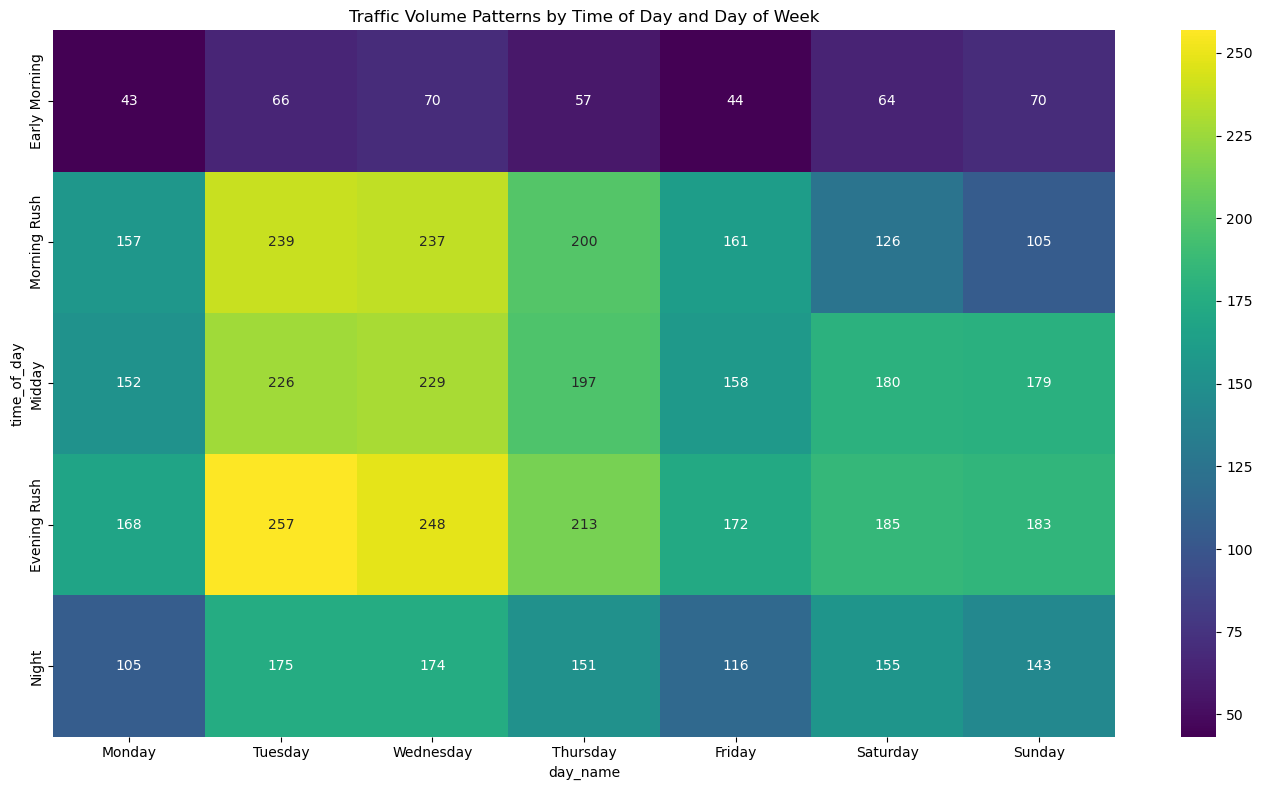

In [12]:
# Visualize key features

# 1. Traffic volume by hour of day
plt.figure(figsize=(12, 6))
hourly_data = df.groupby('HH')['Vol'].mean()
hourly_data.plot(kind='line', marker='o')
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Volume')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Traffic volume by day of week
plt.figure(figsize=(12, 6))
dow_data = df.groupby('day_name')['Vol'].mean()
# Reorder days of week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_data = dow_data.reindex(days_order)
dow_data.plot(kind='bar')
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Volume')
plt.tight_layout()
plt.show()

# 3. Traffic volume by borough
if 'Boro' in df.columns:
    plt.figure(figsize=(12, 6))
    boro_data = df.groupby('Boro')['Vol'].mean().sort_values(ascending=False)
    boro_data.plot(kind='bar')
    plt.title('Average Traffic Volume by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Average Volume')
    plt.tight_layout()
    plt.show()

# 4. Traffic patterns by time of day and day of week
if 'time_of_day' in df.columns and 'day_name' in df.columns:
    plt.figure(figsize=(14, 8))
    pivot_data = df.pivot_table(values='Vol', index='time_of_day', columns='day_name', aggfunc='mean')
    # Reorder columns for days of week
    pivot_data = pivot_data.reindex(columns=days_order)
    sns.heatmap(pivot_data, cmap='viridis', annot=True, fmt='.0f')
    plt.title('Traffic Volume Patterns by Time of Day and Day of Week')
    plt.tight_layout()
    plt.show()

## Save Engineered Traffic Data

Now that we've created useful features from the traffic data, let's save it for later use in our modeling.

In [13]:
# Create final data directory if it doesn't exist
final_data_dir = '../data/final/'
os.makedirs(final_data_dir, exist_ok=True)

# Generate a filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"traffic_engineered_{timestamp}.csv"
output_path = os.path.join(final_data_dir, output_filename)

# Save the dataframe with all engineered features
df.to_csv(output_path, index=False)

# Provide summary of the saved data
num_features = len(df.columns)
num_rows = len(df)
file_size_mb = os.path.getsize(output_path) / (1024 * 1024)

print(f"Traffic dataset successfully saved to: {output_path}")
print(f"Dataset summary:")
print(f"  - Rows: {num_rows:,}")
print(f"  - Features: {num_features}")
print(f"  - File size: {file_size_mb:.2f} MB")

# Create a simpler version without the timestamp for easier reference
standard_filename = "traffic_engineered.csv"
standard_path = os.path.join(final_data_dir, standard_filename)
df.to_csv(standard_path, index=False)
print(f"\nAlso saved a reference copy to: {standard_path}")

# List new features added to the dataset
original_columns = ['Vol', 'Yr', 'M', 'D', 'HH', 'MM', 'WktGeom', 'Boro', 'street', 'Direction', 'datetime_hour']
new_features = [col for col in df.columns if col not in original_columns]

print(f"\nAdded {len(new_features)} new features:")
for i, feature in enumerate(new_features):
    print(f"  {i+1}. {feature}")

Traffic dataset successfully saved to: ../data/final/traffic_engineered_20250719_195258.csv
Dataset summary:
  - Rows: 71,328
  - Features: 43
  - File size: 29.06 MB

Also saved a reference copy to: ../data/final/traffic_engineered.csv

Added 32 new features:
  1. day_of_week
  2. is_weekend
  3. day_name
  4. time_of_day
  5. season
  6. is_peak_hour
  7. hourly_mean_vol
  8. rel_volume
  9. volume_category
  10. vol_zscore
  11. is_vol_outlier
  12. boro_Bronx
  13. boro_Brooklyn
  14. boro_Manhattan
  15. boro_Queens
  16. boro_Staten Island
  17. boro_avg_vol
  18. boro_rel_vol
  19. direction_cardinal
  20. dir_EB
  21. dir_NB
  22. dir_SB
  23. dir_WB
  24. is_major_street
  25. dow_hour_key
  26. typical_vol_for_time
  27. vol_vs_typical
  28. congestion_index
  29. location_id
  30. location_weekday_vol
  31. location_weekend_vol
  32. weekday_weekend_ratio

Also saved a reference copy to: ../data/final/traffic_engineered.csv

Added 32 new features:
  1. day_of_week
  2. is_we